In [1]:
import pandas as pd
import numpy as np
import mygrad as mg
from mygrad import Tensor

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

import liveplot
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
train = pd.read_csv('emnist/emnist-balanced-train.csv').values
test = pd.read_csv('emnist/emnist-balanced-test.csv').values

    

In [3]:
mapping = []
with open('emnist-balanced-mapping.txt',mode='r') as f:
    lines = f.readlines()
    for line in lines:
         mapping.append(chr(int(line.split()[1])))
       

In [4]:
x_train = train[:,1:].reshape(-1,1,28,28).transpose(0,1,3,2)
y_train = train[:,0]
x_test = test[:,1:].reshape(-1,1,28,28).transpose(0,1,3,2)
y_test = test[:,0]
x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")
x_test = np.pad(x_test, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")

In [5]:
len(mapping)

47

In [6]:
x_train.shape, y_train.shape

((112799, 1, 32, 32), (112799,))

<IPython.core.display.Javascript object>


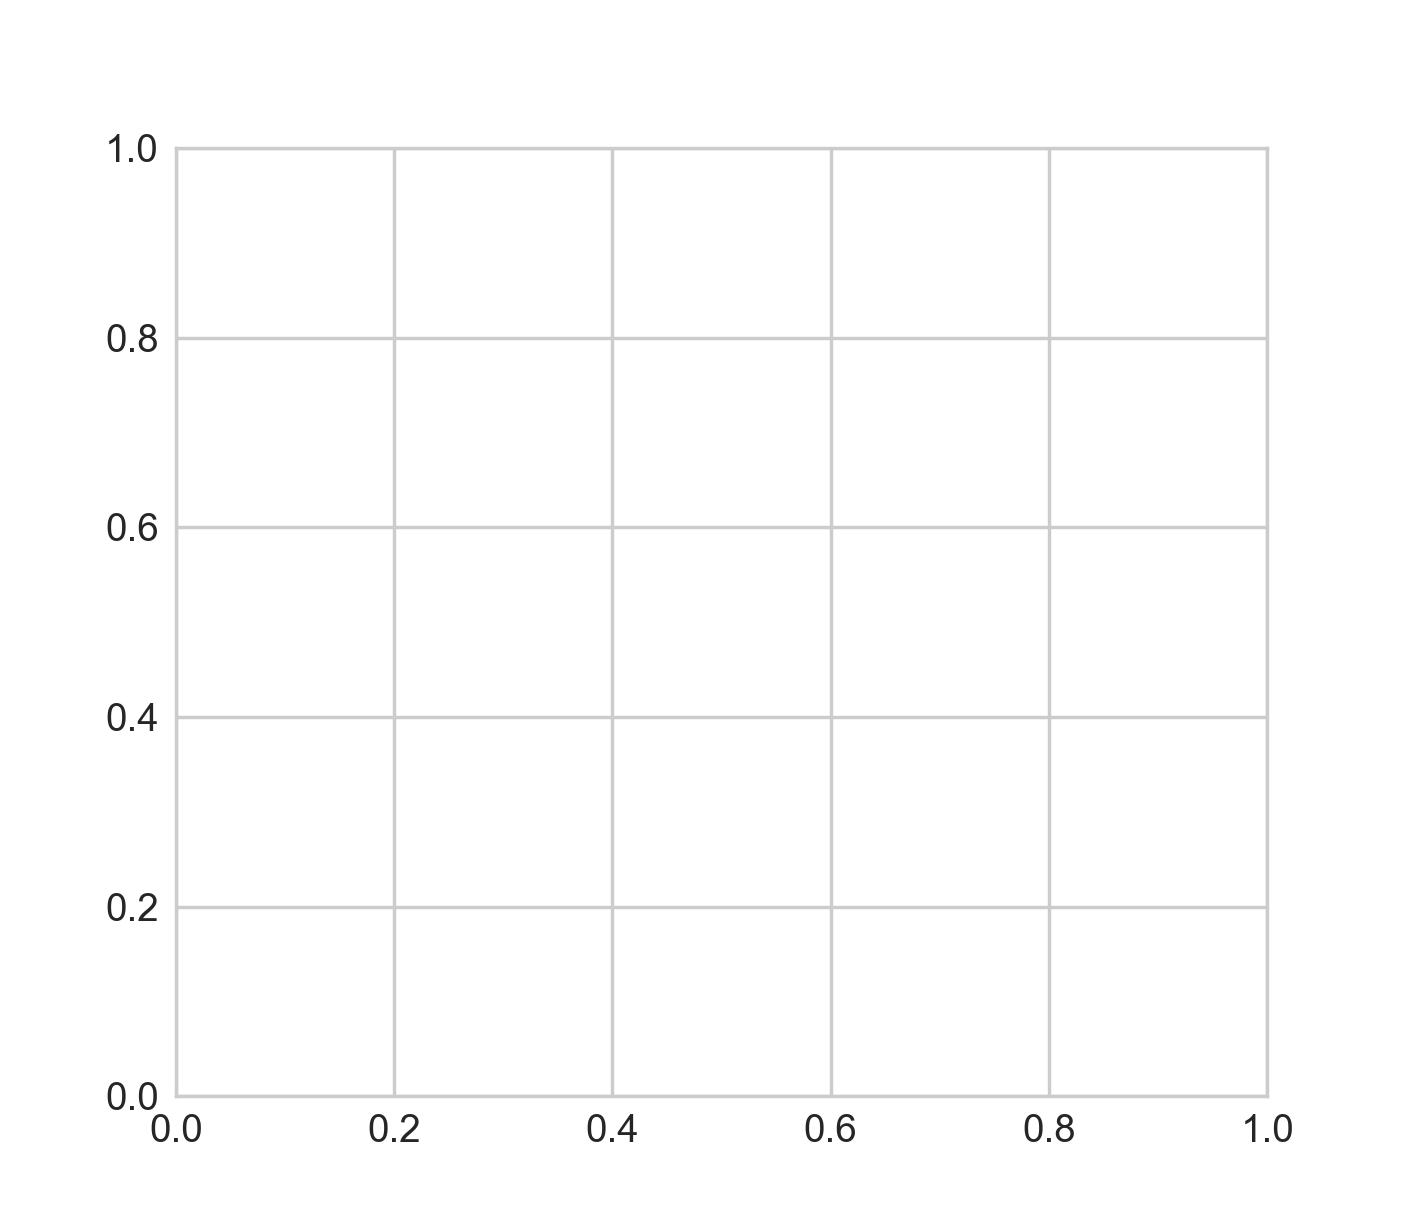

NameError: name 'x_train' is not defined

In [20]:
i = np.random.randint(112800)

fig, ax = plt.subplots()

ax.imshow(x_train[i, 0], cmap="gray")

print(x_train[i])
print(mapping[y_train[i]])

In [8]:
print(mapping[y_train[0]])

a


In [9]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train / 255
x_test = x_test / 255


In [10]:
x_train.shape

(112799, 1, 32, 32)

In [11]:
def accuracy(predictions, truth):

    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [4]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mygrad.nnet.layers import max_pool
from mynn.initializers.glorot_uniform import glorot_uniform
from mynn.activations.relu import relu


class Model(nn.Module):
    ''' A simple convolutional neural network. '''
    def __init__(self):

        super(Model, self).__init__()  
        
        self.conv1 = nn.Conv2d(1, 16,(5,5),stride=(1,1))
        self.max_pool1 = nn.MaxPool2d((2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(16,16,(5,5),stride=(1,1))
        self.max_pool2 = nn.MaxPool2d((2,2),stride=(2,2))
        self.dense1 = nn.Linear(400,256)
        self.dense2 = nn.Linear(256,47)
        
    
    def forward(self, x):
        
        x = self.max_pool1(self.conv1(x))
        x = self.max_pool2(self.conv2(x)).reshape(len(x),-1)
        

        x = self.dense2(F.relu(self.dense1(x)))

        return x
        
    
  

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
model = Model()
optimizer = torch.optim.Adam(model.parameters())
cross_entropy = nn.CrossEntropyLoss()

In [14]:
nn.LSTMCell

torch.nn.modules.rnn.LSTMCell

<IPython.core.display.Javascript object>


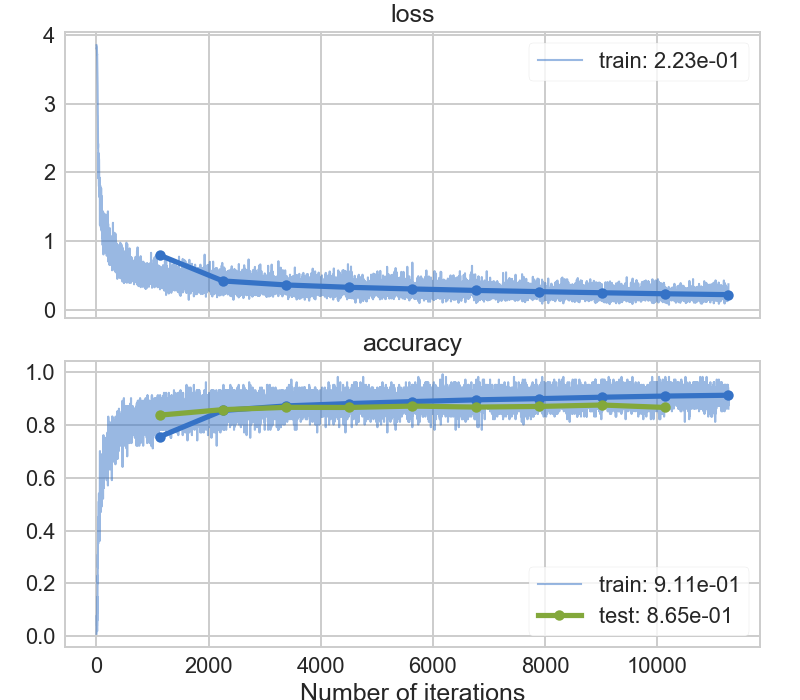

In [15]:

import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

In [16]:

from mynn.losses.cross_entropy import softmax_cross_entropy
batch_size = 100

for epoch_cnt in range(10):
    idxs = np.arange(len(x_train)) 
    np.random.shuffle(idxs)  
    
    
    for batch_cnt in range(0, len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = torch.tensor(x_train[batch_indices])

        prediction = model(batch) 
        truth = torch.tensor(y_train[batch_indices])
        
        loss = cross_entropy(prediction, truth)
        acc = np.mean(np.argmax(prediction.data.numpy(), axis=1) == truth.data.numpy())
        optimizer.zero_grad() # zero_grad is like `null_gradients`
        loss.backward()
        optimizer.step()
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    with torch.no_grad():
        for batch_cnt in range(0, len(x_test)//batch_size):
            idxs = np.arange(len(x_test))
            batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
            batch = torch.tensor(x_test[batch_indices]) 
            prediction = model(batch)
            truth = torch.tensor(y_test[batch_indices])
            acc = np.mean(np.argmax(prediction.numpy(), axis=1) == truth.numpy())
            plotter.set_test_batch({ "accuracy" : acc,},
                                     batch_size=batch_size)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()    

In [18]:
def label_images(images):
    images = torch.tensor(np.array(images).reshape(-1,1,32,32))
    with torch.no_grad():
        predictions = model(images)
        
        confidence = np.max(F.softmax(predictions,dim=1).numpy(),axis=1)
        label_index = list(np.argmax(F.softmax(predictions,dim=1).numpy(),axis=1))
        for i,label in enumerate(label_index):
            label_index[i] = mapping[label]
        return (label_index,confidence)

In [18]:
prediction = label_images(x_train[:3])

In [19]:
prediction

(['a', 'n', 'f'], array([0.9985982 , 0.99821997, 0.61225367], dtype=float32))

In [5]:

with open("emnist_model.pkl", mode="wb") as opened_file:
    pickle.dump(model.state_dict, opened_file)

NameError: name 'pickle' is not defined

In [10]:
import pickle
with open("emnist_model.pkl", mode="rb") as f:
    state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

<bound method Module.state_dict of Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=400, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=47, bias=True)
)>


AttributeError: 'function' object has no attribute 'copy'

In [16]:
from PIL import Image
def open_and_preprocess(path):
    im = Image.open(path)
    im = im.resize((28,28))
    padded = np.pad(im,(2,2),mode="constant",constant_values=0)
    return np.array(padded)

In [30]:
from pathlib import Path
base = Path("data")
images = []
for p in list(base.glob("*.png")):
    images.append(open_and_preprocess(p))
keys = [8,9,4,5,7,6,2,7,3,1,5,0]
images = np.array(images).reshape(len(keys),1,32,32).astype(np.float32) / 255

In [35]:
label_images(images)
#print(images[0,0,5:-5,5:-5])

(['R', 'L', '4', 'Y', 'G', 'Y', 'L', 'L', 'L', 'V', 'U', 'L'],
 array([0.02404739, 0.02406011, 0.02359103, 0.02376219, 0.02362696,
        0.02410376, 0.0238126 , 0.02444613, 0.02347498, 0.02380188,
        0.02369783, 0.02422439], dtype=float32))